
# GapMinder Model Interpretation for Chi-Square and post hoc Chi-Square Tests

In [1]:

import pickle
import pandas as pd

# Handy list of the different types of encodings
encoding = ['latin1', 'iso8859-1', 'utf-8'][1]

# Change this to your data and saves folders
data_folder = r'../../data/'
saves_folder = r'../../saves/'

def load_object(obj_name):
    pickle_path = saves_folder + 'pickle/' + obj_name + '.pickle'
    try:
        object = pd.read_pickle(pickle_path)
    except:
        with open(pickle_path, 'rb') as handle:
            object = pickle.load(handle)
    
    return(object)

In [2]:

from sklearn.decomposition import PCA
import os

obj_path = saves_folder + 'pickle/gapminder_df.pickle'
if not os.path.isfile(obj_path):
    gapminder_df = pd.read_csv(data_folder + 'csv/gapminder.csv',
                               low_memory=False, encoding=encoding)
else:
    gapminder_df = load_object('gapminder_df')
gapminder_df.columns = ['country_name', 'income_per_person',
                        'alcohol_consumption', 'armed_forces_rate',
                        'breast_cancer_per_100th', 'co2_emissions',
                        'female_employment_rate', 'hiv_rate',
                        'internet_use_rate', 'life_expectancy',
                        'oil_per_person', 'polity_score',
                        'residential_electricity_per_person',
                        'suicide_per_100th', 'employment_rate',
                        'urban_rate']
number_column_list = list(set(gapminder_df.columns) - set(['country_name']))
elite_df = gapminder_df.dropna(how='any').copy()
elite_ndarray = PCA(n_components=2).fit_transform(elite_df[number_column_list])

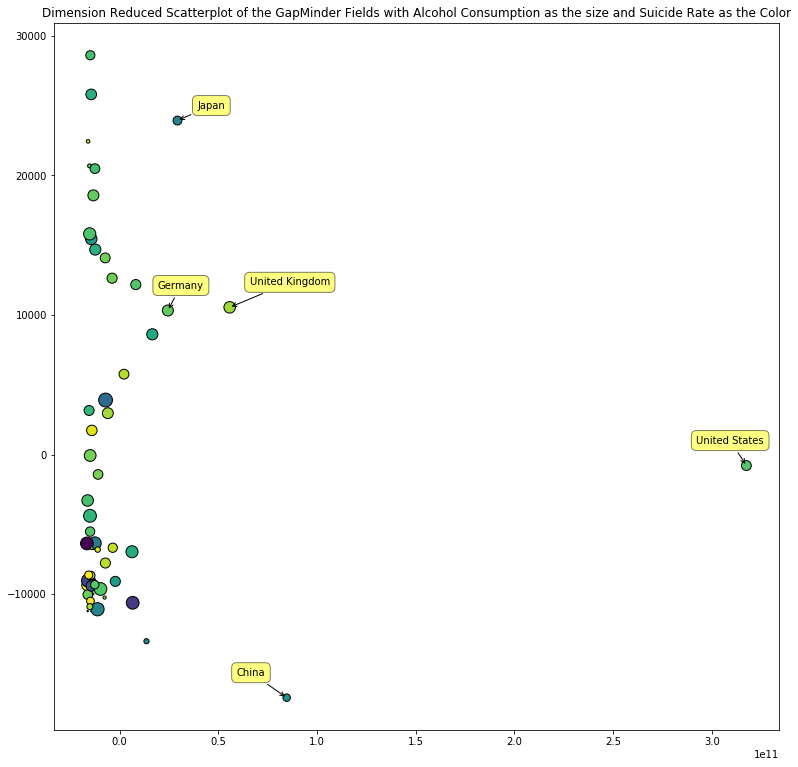

In [3]:

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=7750000000, min_samples=2).fit(elite_ndarray)
labels = db.labels_

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, autoscale_on=True)
cmap = plt.get_cmap('viridis_r')
path_collection = ax.scatter(elite_ndarray[:, 0], elite_ndarray[:, 1],
                             s=elite_df['alcohol_consumption']*10,
                             c=elite_df['suicide_per_100th'],
                             edgecolors=(0, 0, 0), cmap=cmap)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
for col, label, x, y in zip(labels, elite_df['country_name'],
                            elite_ndarray[:, 0], elite_ndarray[:, 1]):
    if (label == 'Japan'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 10), **kwargs)
    elif (label == 'United Kingdom'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, 20), **kwargs)
    elif (label == 'China') or (label == 'United States'):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-50, 20), **kwargs)
    elif (col == 1):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-10, 20), **kwargs)
title_text = 'Dimension Reduced Scatterplot of the GapMinder '
title_text += 'Fields with Alcohol Consumption as the size and '
title_text += 'Suicide Rate as the Color'
text = plt.title(title_text)

In [4]:

def create_binned_categories(df, number_of_categories, column_name, prefix):
    
    # Get the percentiles
    out_categorical, percentiles_list = pd.cut([0, 1], number_of_categories, retbins=True)
    describe_series = df[column_name].describe(percentiles=percentiles_list[1:-1]).copy()

    # Get the bin list and group names
    bad_list = ['count', 'mean', 'std']
    if (number_of_categories % 2) == 1:
        bad_list += ['50%']
    index_list = [x for x in describe_series.index.tolist() if x not in bad_list]
    bin_list = describe_series.loc[index_list].tolist()

    # Create the extra column
    df[prefix+'_categories'] = pd.cut(df[column_name],
                                      bin_list).map(lambda x: (x.left + x.right)/2.)

    # Fix the bottom row
    null_series = df[prefix+'_categories'].isnull()
    df.loc[null_series, prefix+'_categories'] = df[~null_series][prefix+'_categories'].min()

    return df

In [5]:

def chi_square_test_of_independence(df, number_of_categories,
                                    ce_column, cr_column,
                                    ce_formal_name, cr_formal_name,
                                    ce_informal_name, cr_informal_name,
                                    sample_name='the population', verbose=False):
    df = create_binned_categories(df, 2, cr_column, 'cr')
    df = create_binned_categories(df, number_of_categories, ce_column, 'ce')
    
    return model_interpretation(df,
                                'ce_categories', 'cr_categories',
                                ce_formal_name, cr_formal_name,
                                ce_informal_name, cr_informal_name,
                                sample_name, verbose)

In [10]:

%matplotlib inline
from IPython.display import HTML
from scipy.stats import chi2_contingency
import seaborn

# Chi Square test of independence
def model_interpretation(df,
                         ce_column, cr_column,
                         ce_formal_name, cr_formal_name,
                         ce_informal_name, cr_informal_name,
                         sample_name='the population', verbose=False):
    
    # Categorical explanatory variable
    df[ce_column] = df[ce_column].astype('float64')
    
    # Categorical response variable
    df[cr_column] = df[cr_column].astype('float64')
    
    crosstab_df = pd.crosstab(df[cr_column], df[ce_column])
    if verbose:
        print()
        print('Contingency table of observed counts')
        print(crosstab_df)
    
    if verbose:
        colsum_series = crosstab_df.sum(axis=0)
        colpct_df = crosstab_df/colsum_series
        print()
        print('Column percentages')
        print(colpct_df)
    
    chi2_contingency_tuple = chi2_contingency(crosstab_df)
    if verbose:
        print()
        print('Chi-square')
        explanation_list = ['The test statistic', 'The p-value of the test', 'Degrees of freedom',
                            'The expected frequencies (based on the marginal sums of the table)']
        for x, y in zip(explanation_list, chi2_contingency_tuple):
            print('{}: {}'.format(x, y))
    
    # Get statement
    chi_squared = str('%.2f' % chi2_contingency_tuple[0])
    p_value = chi2_contingency_tuple[1]
    degrees_of_freedom = str('%d' % chi2_contingency_tuple[2])
    if p_value < 0.0001:
        pvalue_statement = '<0.0001'
    else:
        pvalue_statement = '=' + str('%.4f' % p_value)
    post_HTML = ''
    if p_value < 0.05:
        adverb_significant = 'significantly'
        
        # Get post hoc statement: assume at least one pair will be statistically significant
        post_HTML = ('<p>Post hoc comparisons of ' +
                     cr_informal_name + ' by pairs of ' +
                     ce_informal_name + ' categories revealed that that the prevalence of ' +
                     cr_informal_name + ' was statistically dissimilar between ')
        category_list = sorted(df[ce_column].unique().tolist())
        num_categories = len(category_list)
        bonferroni_threshold = 0.1/num_categories*(num_categories+1)
        similar_list = []
        dissimilar_list = []
        for left_category in category_list:
            for right_category in category_list[1:]:
                if left_category < right_category:
                    
                    # Match the left or right categories; recodes don't work because of floating point error
                    match_series = (df[ce_column] == left_category) | (df[ce_column] == right_category)
                    binary_series = df[match_series][ce_column]
                    
                    # Get the binary cross tab
                    binary_df = pd.crosstab(df[cr_column], binary_series)
                    
                    if binary_df.shape[0] > 0:
                        
                        # Get the binary p value
                        chi2_contingency_tuple = chi2_contingency(binary_df)
                        binary_pvalue = chi2_contingency_tuple[1]
                        
                        # Put them in similar or dssimilar groups
                        grouping_HTML = ('the <code>' +
                                         str('%.3f' % left_category) + '</code> group compared to the <code>' +
                                         str('%.3f' % right_category) + '</code> group')
                        if binary_pvalue < bonferroni_threshold:
                            dissimilar_list.append(grouping_HTML)
                        else:
                            similar_list.append(grouping_HTML)
                            
        if len(dissimilar_list):
            post_HTML += ', and '.join([', '.join(dissimilar_list[:-1])] + [dissimilar_list[-1]]) + '.'
        else:
            post_HTML += 'no groups at the Bonferroni adjustment of p=' + str(bonferroni_threshold) + '.'
        if len(similar_list):
            post_HTML += (' In comparison, prevalence of ' +
                          cr_informal_name + ' was statistically similar among ' +
                          ', and '.join([', '.join(similar_list[:-1])] + [similar_list[-1]]) + '.')
        post_HTML += '</p>'
        
    else:
        adverb_significant = 'insignificantly'
    chi_HTML = ('<h3>Model Interpretation for Chi-Square Tests:</h3><p>A Chi Square test of independence revealed that among ' +
                sample_name + ', ' +
                ce_formal_name + ' (categorical explanatory variable collapsed into ' +
                str(num_categories) + ' ordered categories), and ' +
                cr_formal_name + ' (binary categorical response variable) were ' +
                adverb_significant + ' associated, X2=' +
                chi_squared + ', ' +
                degrees_of_freedom + ' df, p' +
                pvalue_statement + '.</p>')
    
    if verbose:
        print()
        facet_grid = seaborn.factorplot(x=ce_column, y=cr_column, data=df, kind='bar', ci=None, size=10)
        xlabel = plt.xlabel(ce_formal_name + ', group averages')
        ylabel = plt.ylabel(cr_formal_name)
        title = plt.title('Graph percent with ' + str(cr_informal_name) + ' within each ' + str(ce_informal_name) + ' group')
    
    return HTML(chi_HTML + post_HTML)


Contingency table of observed counts
ce_categories  1.830   6.520   10.265  12.220  16.245
cr_categories                                        
5.6870              8       7       6       6       1
21.6675             4       4       5       5      10

Column percentages
ce_categories    1.830     6.520     10.265    12.220    16.245
cr_categories                                                  
5.6870         0.666667  0.636364  0.545455  0.545455  0.090909
21.6675        0.333333  0.363636  0.454545  0.454545  0.909091

Chi-square
The test statistic: 9.696969696969695
The p-value of the test: 0.045853569984819556
Degrees of freedom: 4
The expected frequencies (based on the marginal sums of the table): [[ 6.   5.5  5.5  5.5  5.5]
 [ 6.   5.5  5.5  5.5  5.5]]



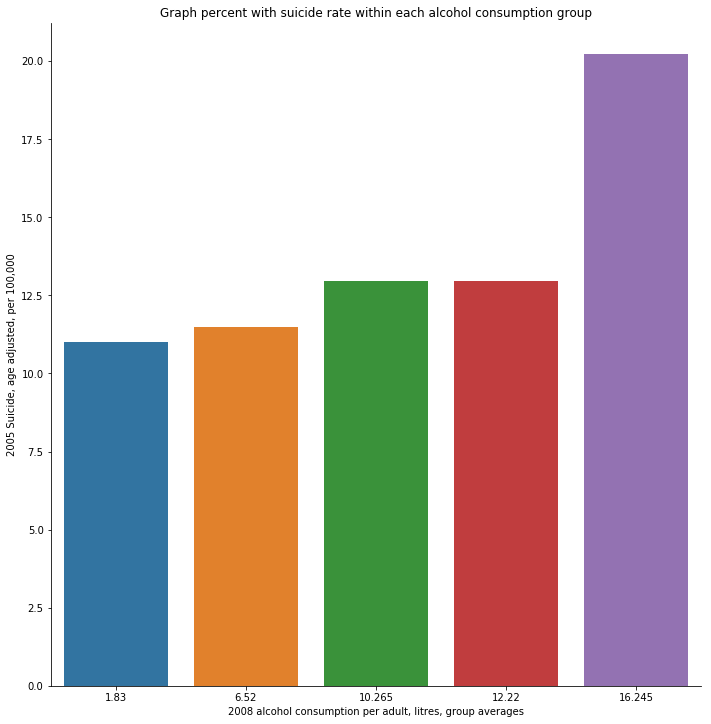

In [11]:

sample_name = 'the sample of ' + str(elite_df.shape[0]) + ' countries from GapMinder.org'
chi_square_test_of_independence(elite_df, 5,
                                'alcohol_consumption', 'suicide_per_100th',
                                '2008 alcohol consumption per adult, litres', '2005 Suicide, age adjusted, per 100,000',
                                'alcohol consumption', 'suicide rate', sample_name, verbose=True)

In [8]:

%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "notebook_name = " + "'"+attribs['data-notebook-name'].value+"'";
var command = "notebook_path = " + "'"+attribs['data-notebook-path'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [9]:
# %load ../../../load_magic/nbviewer.py

from IPython.display import HTML

notebook_viewer_url = 'https://nbviewer.jupyter.org/github/dbabbitt/notebooks/blob/master/' + notebook_path
HTML('Click <a href="' + notebook_viewer_url + '" target="_blank">here</a> to view notebook in nbviewer.')